In [1]:
#!/usr/bin/env python3
# Importing all required dependencies
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] : 20
import scipy.special as sp
import nlopt
from scipy.stats import norm, chi2, uniform, lognorm
from scipy.interpolate import UnivariateSpline

In [2]:
def model(L, Delta, T, a):
    # Function to return the PDE solution at time T, at positions in the vector xloc 
    N = int(2 * L / Delta) + 1  # Number of mesh points on domain -L < x < L with uniform mesh spacing Delta
    xloc = np.linspace(-L, L, N)
    # Exact solution with parameters a = [U0, h, D, v]
    def c(x):
        # a[0]=U0, a[1]=h, a[2]=D, a[3]=v
        return a[0] * (sp.erf((a[1] - (x - a[3] * T)) / np.sqrt(4 * a[2] * T)) + 
                       sp.erf((a[1] + (x - a[3] * T)) / np.sqrt(4 * a[2] * T))) / 2
    y = c(xloc)
    return y

### Process model for density $u(x,t) \ge 0$

\begin{equation*}
\large{\dfrac{\partial u}{\partial t} = D \dfrac{\partial^2 u}{\partial x^2} - v \dfrac{\partial u}{\partial x} } 
\end{equation*}

### Initial condition

\begin{align*}
\large{u(x,0)} &\large{= u_b,} \quad \large{ |x| > h}, \notag \\
\large{u(x,0)} &\large{= u_b+u_0,} \quad \large{ |x| < h,} \notag \\
\end{align*}

### Exact solution

\begin{equation*}
\large{u(x,t) =  u_b + \dfrac{u_0}{2}\left[\textrm{erf}\left(\dfrac{h-(x-vt)}{2\sqrt{Dt}}\right)+\textrm{erf}\left(\dfrac{h+(x-vt)}{2\sqrt{Dt}}\right)  \right]},
\end{equation*}

### Parameters

\begin{equation*}
\large{\theta = (u_0,h,D,v)^\top}.
\end{equation*}

In [3]:
def loglhood2(data, a, L, Delta, T, xloc, sigma):

    # Evaluate the model solution with parameters a = [U0, h, D, v]
    y = model(L, Delta, T, a)
    # Ensure valid values (avoid zero division)
    valid_mask = (y > 0) & (data > 0)
    if not np.any(valid_mask):
        return -np.inf  # If no valid data points, return negative infinity log-likelihood
    # Compute the ratio where both data and model values are valid
    ratio = data[valid_mask] / y[valid_mask]
    # Log-normal log-probability density function (PDF)
    dist = lognorm(sigma, scale=1)
    # Compute log-likelihood using vectorized operations
    log_likelihood = np.sum(dist.logpdf(ratio))

    return log_likelihood    

In [15]:
def loglhood(data, a, L, Delta, T, xloc, sigma):
    # Evaluate the model solution with parameters a = [U0, h, D, v]
    y = model(L, Delta, T, a)

    # Ensure valid values (avoid zero division) and avoid recalculating
    valid_mask = (y > 0) & (data > 0)
    
    if not np.any(valid_mask):  # If no valid data points, return negative infinity log-likelihood
        return -np.inf
    
    # Compute the ratio of data to model values where both are valid
    ratio = data[valid_mask] / y[valid_mask]
    
    # Log-normal log-probability density function (PDF)
    dist = lognorm(sigma, scale=1)
    
    # Compute the log-likelihood using vectorized operations (sum of logpdfs)
    log_likelihood = np.sum(dist.logpdf(ratio))  # vectorized sum of log PDFs

    return log_likelihood

## Noise model: Log-Normal 


\begin{equation*}
\large{u^{\textrm{obs}}(x_i,t) \mid \theta = \left[u(x_i,t) \mid \theta\right]\eta_i,} \quad \large{\eta_i \sim \textrm{log-normal} (0,\sigma^2)}
\end{equation*}


## Equivalently 

\begin{equation*}
\large{u^{\textrm{obs}}(x_i,t) \mid \theta = \left[u(x_i,t) \mid \theta)\right]\textrm{exp}(\varepsilon),} \quad \large{\varepsilon \sim \mathcal{N}(0,\sigma^2)}
\end{equation*}


## Log-likelihood function

\begin{equation*}
	\large{\ell(\theta \mid u^\textrm{obs}(x_i,t)) = \sum_{i=1}^{I} \log \left[\phi\left(u^\textrm{obs}(x_i,t); \log(u(x_i,t)), \sigma^2 \right)\right]}.
\end{equation*}

In [16]:
a = np.zeros(4)  # a=zeros(4)
def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (U0, h, D, v)
    return loglhood(data, a, L, Delta, T, xloc, sigma)

In [17]:
def Optimise(fun, theta0, lb, ub):
    # Optimize finds the values of parameters theta that maximise the objective function fun with lower bounds lb, and upper bounds ub
    # In Julia: tomax=(θ,∂θ)->fun(θ)
    # In Python NLopt minimizes the objective so we define an objective that returns -fun(theta)
    def objective(theta, grad):
        return -fun(theta)
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(theta0))
    opt.set_min_objective(objective)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    # Set maximum time in seconds (maxtime in Julia)
    opt.set_maxtime(10*60)
    xopt = opt.optimize(np.array(theta0))
    # In NLopt, the result returned by optimization is the minimizer of the negative objective.
    fopt = -opt.last_optimum_value()
    return xopt, fopt

In [18]:
# Set up parameters and discretisation
L = 200  # set up the domain -200< x < 200, discretised with mesh spacing Delta
Delta = 5
N = int(2 * L / Delta) + 1
xloc = np.zeros(N)
for i in range(1, N+1):
    xloc[i-1] = -L + (i - 1) * Delta

# Set parameter values
D = 10.0  
v = 1.0   
T = 50
U0 = 1.0  
h = 50     
sigma = 1.0 / 5.0

# Define functions f and g as in Julia
def f_func(x):
    return 0.0

def g_func(x):
    return U0

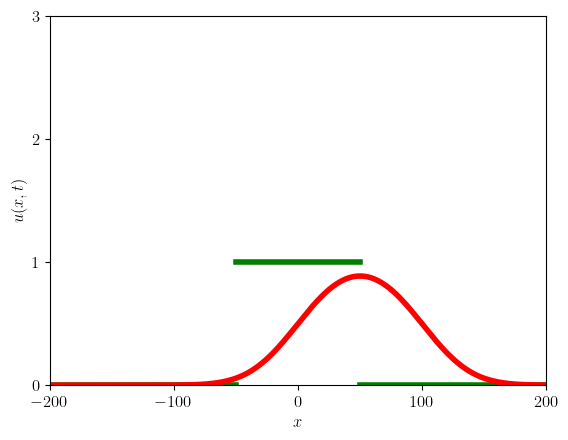

In [19]:
# Plot initial condition and solution at time T
x_plot_line = np.linspace(-L, L, 400)
# Create the first plot p1
fig1, ax1 = plt.subplots()
# Plot f from -L to -h
x_range1 = np.linspace(-L, -h, 200)
ax1.plot(x_range1, [f_func(x) for x in x_range1], lw=4, color='green', label='_nolegend_')
# Plot f from h to L
x_range2 = np.linspace(h, L, 200)
ax1.plot(x_range2, [f_func(x) for x in x_range2], lw=4, color='green', label='_nolegend_')
# Plot g from -h to h
x_range3 = np.linspace(-h, h, 200)
ax1.plot(x_range3, [g_func(x) for x in x_range3], lw=4, color='green', label='_nolegend_')
# Define u(x)= U0*(erf((h-(x-v*T))/sqrt(4*D*T))+erf((h+(x-v*T))/sqrt(4*D*T)))/2;
def u(x):
    return U0 * (sp.erf((h - (x - v * T)) / np.sqrt(4 * D * T)) + sp.erf((h + (x - v * T)) / np.sqrt(4 * D * T))) / 2
ax1.plot(x_plot_line, [u(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax1.set_xlabel(r"$x$",fontsize=12)
ax1.set_ylabel(r"$u(x,t)$",fontsize=12)
ax1.set_xlim(-L, L)
ax1.set_ylim(0, 3)
ax1.set_xticks([-200, -100, 0, 100, 200])
ax1.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax1.tick_params(labelsize=12)

In [20]:
#Fixed data generated by solving the process model and corrupting the solution with multiplicative log-normal noise with sigma=0.2 
data =  np.array([1.443529214802643e-10,
2.3218269790487678e-10,
1.0228639233757297e-9,
1.805676854138166e-9,
4.840278669608082e-9,
1.7039099334160228e-8,
4.2487847359203066e-8,
1.0897076488179797e-7,
1.6297115566204057e-7,
5.619380728678323e-7,
1.27607240633502e-6,
2.11026670323913e-6,
7.23659951163088e-6,
1.0355981844404721e-5,
2.297839380764977e-5,
3.515164745692764e-5,
9.420598475706468e-5,
0.00018648942209725184,
0.00030874873490431787,
0.0006722105184516749,
0.0007643851188759354,
 0.0013215399694911142,
 0.0021727863700348256,
 0.0036629275218593993,
 0.00588360993881856,
 0.0062694002983311,
 0.014803296353026425,
 0.01951203266481328,
 0.02407215297691123,
 0.04171503969089537,
 0.04397004901777453,
 0.0717014303967583,
 0.11151745578656194,
 0.12976000843879903,
 0.14086246684559256,
 0.1870022738251664,
 0.2501776103308435,
 0.29466463480742117,
 0.533350088841853,
 0.37821234635970064,
 0.7015423565364873,
 0.556565589913085,
 0.45279561548388,
 0.9817770380772471,
 0.7313368944696472,
 0.7816145735619514,
 1.049339216720264,
 0.7662825270723039,
 1.1927507203925707,
 0.9704088510373458,
 0.9508912611533775,
 0.6382250802017383,
 0.9260205533028476,
 0.8055751403061922,
 0.6882395782605749,
 0.8958340909215593,
 0.6445706982093314,
 0.5436695103453301,
 0.5012595454482108,
 0.4170150857092262,
 0.45954676296469504,
 0.3426768404377206,
 0.4012976322328738,
 0.4253142813391668,
 0.2458843401540494,
 0.15885386265508783,
 0.19381988029839897,
 0.09551123321734424,
 0.09904587148790636,
 0.08911538395417264,
 0.049742505161755615,
 0.05251969031689682,
 0.035388426388368435,
 0.024952113255135203,
 0.013456312282987123,
 0.00803477659176543,
 0.00818937282914698,
 0.0027920787549109345,
 0.00223917121213745,
 0.0012290739636724294,
 0.0007845603474930095]);  

Optimization time: 0.2545 seconds


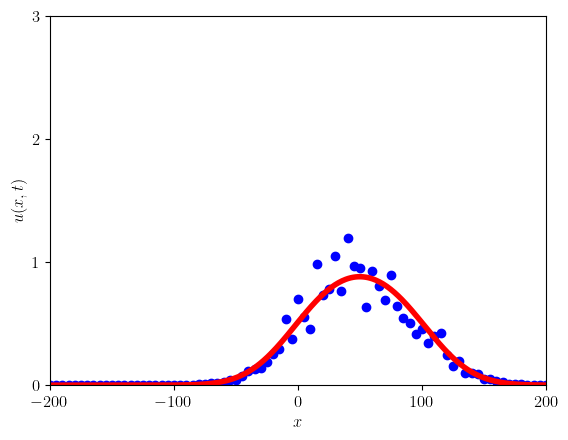

In [21]:
thetaG = [1.0, 50, 10, 1]  # Initial parameter estimates for the iterative optimization solver
lb = [0, 0, 0.01, -10]    # lower bounds
ub = [10, L, 100, 10]      # upper bounds

# Timing the optimization as in Julia: @time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
start_time = time.time()
xopt, fopt = Optimise(funmle, thetaG, lb, ub)
print("Optimization time: {:.4f} seconds".format(time.time() - start_time))

U0mle = xopt[0]  # Store MLE
hmle = xopt[1]   # Store MLE
Dmle = xopt[2]   # Store MLE
vmle = xopt[3]   # Store MLE
fmle = fopt      # Store log-likelihood value at the MLE

# MLE solution: umle(x)=Ub+U0mle*(erf((hmle-(x-vmle*T))/sqrt(4*Dmle*T))+erf((hmle+(x-vmle*T))/sqrt(4*Dmle*T)))/2;
def umle(x):
    return U0mle * (sp.erf((hmle - (x - vmle * T)) / np.sqrt(4 * Dmle * T)) \
           + sp.erf((hmle + (x - vmle * T)) / np.sqrt(4 * Dmle * T))) / 2

# Plotting the data and MLE solution
fig2, ax2 = plt.subplots()
ax2.scatter(xloc, data, color='blue', label='_nolegend_')
ax2.plot(x_plot_line, [umle(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax2.set_xlabel(r"$x$",fontsize=12)
ax2.set_ylabel(r"$u(x,t)$",fontsize=12)
ax2.set_xlim(-L, L)
ax2.set_ylim(0, U0 + 0.1)
ax2.set_xticks([-200, -100, 0, 100, 200])
ax2.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax2.tick_params(labelsize=12)

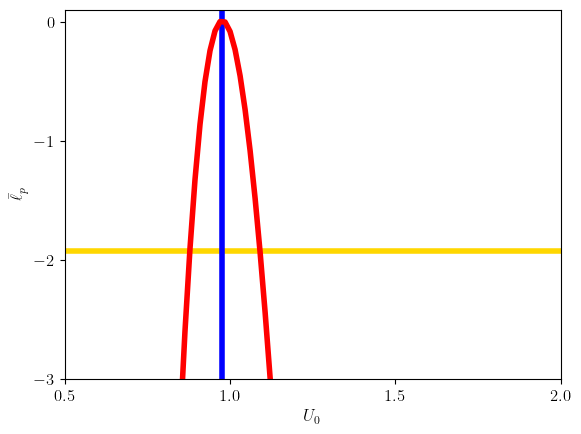

In [22]:
# Set degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
df = 1  # degrees of freedom
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariateU0(U0_val):
    a_local = np.zeros(3)
    def funU0(a_nuisance):
        # Evaluate the log-likelihood at a specified value U0
        a_full = np.array([U0_val, a_nuisance[0], a_nuisance[1], a_nuisance[2]])
        return loglhood(data, a_full, L, Delta, T, xloc, sigma)
    thetaG_local = [hmle, Dmle, vmle]  # Estimate of the nuisance parameters h, D, v
    lb_local = [0, 0.01, -100]  # Lower bounds for nuisance parameters h, D, v
    ub_local = [L, 1000, 100]  # Upper bounds for nuisance parameters h, D, v
    xopt_local, fopt_local = Optimise(funU0, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_U0(x):
    return univariateU0(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
U0range = np.linspace(0.5, 2.0, M)
ff = np.zeros(M)
for i in range(M):
    ff[i] = univariateU0(U0range[i])[0]  # Compute the profile log-likelihood over the M mesh points
#Plot the normalised profile log-likelihood for U0, superimposed with the MLE and 95% threshold 
fig4, ax4 = plt.subplots()
ax4.axhline(llstar, lw=4, color='gold', label='_nolegend_')
ax4.axvline(U0mle, lw=4, color='blue', label='_nolegend_')
#Spline1D: using UnivariateSpline with specified smoothing factor s and degree k=3
spl = UnivariateSpline(U0range, ff - np.max(ff), k=3, s=0.0001)
yy = spl(U0range)
ax4.plot(U0range, yy, lw=4, color='red')
ax4.set_ylim(-3, 0.1)
ax4.set_xlim(0.5,2.0)
ax4.set_xticks([0.5, 1.0, 1.5, 2.0])
ax4.set_xticklabels([r"$0.5$", r"$1.0$", r"$1.5$", r"$2.0$"],fontsize=12)
ax4.set_yticks([-3, -2, -1, 0])
ax4.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax4.tick_params(labelsize=12)
plt.xlabel(r"$U_0$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12);

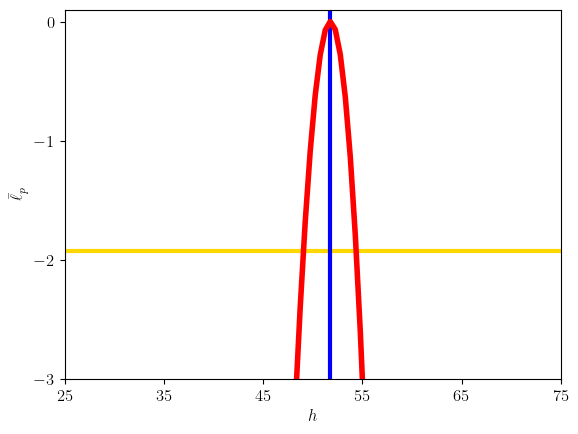

In [11]:
def univariateh(h_val):
    a_local = np.zeros(3)
    def funh(a_nuisance):
        # Evaluate the log-likelihood at a specified value h
        a_full = np.array([a_nuisance[0], h_val, a_nuisance[1], a_nuisance[2]])
        return loglhood(data, a_full, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, Dmle, vmle]  # Estimate of the nuisance parameters U0, D, v
    lb_local = [0, 0.01, 0]  # Lower bounds for the nuisance parameters U0, D, v
    ub_local = [100, 1000, 100]  # Upper bounds for the nuisance parameters U0, D, v
    xopt_local, fopt_local = Optimise(funh, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_h(x):
    return univariateh(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
hrange = np.linspace(25, 75, M)
ff_h = np.zeros(M)
for i in range(M):
    ff_h[i] = univariateh(hrange[i])[0]  # Compute the profile log-likelihood over the M mesh points
# Plot the normalised profile log-likelihood for h, superimposed with the MLE and 95% threshold
fig5, ax5 = plt.subplots()
ax5.axhline(llstar, lw=3, color='gold', label='_nolegend_')
ax5.axvline(hmle, lw=3, color='blue', label='_nolegend_')
spl_h = UnivariateSpline(hrange, ff_h - np.max(ff_h), k=3, s=0.0001)
yy_h = spl_h(hrange)
ax5.plot(hrange, yy_h, lw=4, color='red')
ax5.set_ylim(-3, 0.1)
ax5.set_xlim(hrange[0], hrange[-1])
ax5.set_xticks([25, 35, 45, 55, 65, 75])
ax5.set_xticklabels([r"$25$", r"$35$", r"$45$", r"$55$", r"$65$", r"$75$"],fontsize=12)
ax5.set_yticks([-3, -2, -1, 0])
ax5.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax5.tick_params(labelsize=12)
plt.xlabel(r"$h$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12);

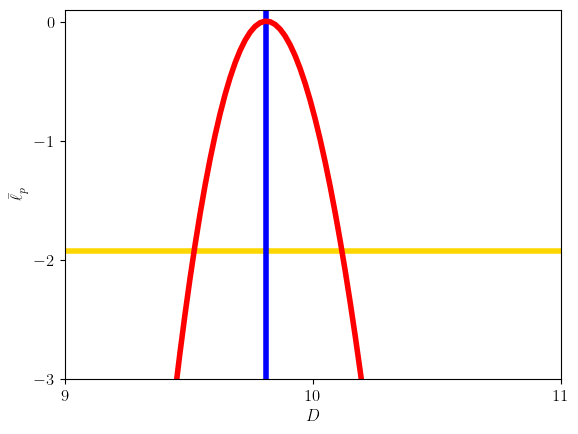

In [12]:
def univariateD(D_val):
    a_local = np.zeros(3)
    def funD(a_nuisance):
        # Evaluate the log-likelihood at a specified value D
        a_full = np.array([a_nuisance[0], a_nuisance[1], D_val, a_nuisance[2]])
        return loglhood(data, a_full, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, hmle, vmle]  # Estimate of the nuisance parameters U0, h, v
    lb_local = [0, 0, 0]  # Lower bounds for the nuisance parameters U0, h, v
    ub_local = [100, L, 100]  # Upper bounds for the nuisance parameters U0, h, v
    xopt_local, fopt_local = Optimise(funD, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_D(x):
    return univariateD(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
Drange = np.linspace(9, 11, M)
ff_D = np.zeros(M)
for i in range(M):
    ff_D[i] = univariateD(Drange[i])[0]  # Compute the profile log-likelihood over the M mesh points
    
# Plot the normalised profile log-likelihood for D, superimposed with the MLE and 95% threshold
fig6, ax6 = plt.subplots()
ax6.axhline(llstar, lw=4, color="gold", label='_nolegend_')
ax6.axvline(Dmle, lw=4, color='blue', label='_nolegend_')
spl_D = UnivariateSpline(Drange, ff_D - np.max(ff_D), k=3, s=0.001)
yy_D = spl_D(Drange)
ax6.plot(Drange, yy_D, lw=4, color='red')
ax6.set_ylim(-3, 0.1)
ax6.set_xlim(Drange[0], Drange[-1])
ax6.set_xticks([9, 10, 11])
ax6.set_xticklabels([r"$9$", r"$10$", r"$11$"],fontsize=12)
ax6.set_yticks([-3, -2, -1, 0])
ax6.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax6.tick_params(labelsize=12)
plt.xlabel(r"$D$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12);

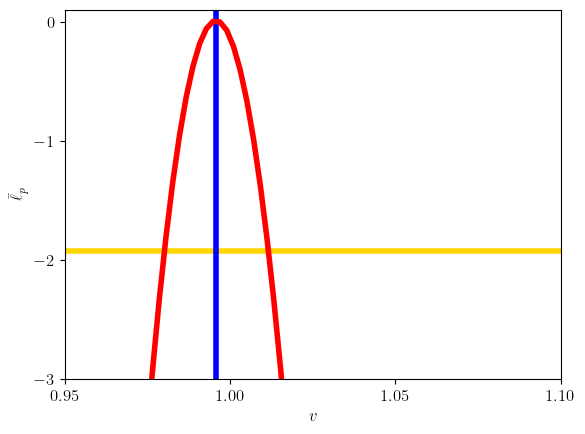

In [13]:
def univariatev(v_val):
    a_local = np.zeros(3)
    def funv(a_nuisance):
        # Evaluate the log-likelihood at a specified value v
        a_full = np.array([a_nuisance[0], a_nuisance[1], a_nuisance[2], v_val])
        return loglhood(data, a_full, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, hmle, Dmle]  # Estimate of the nuisance parameters U0, h, D
    lb_local = [0, 0, 0.01]  # Lower bound of the nuisance parameters U0, h, D
    ub_local = [100, L, 1000]  # Upper bound of the nuisance parameters U0, h, D
    xopt_local, fopt_local = Optimise(funv, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_v(x):
    return univariatev(x)[0]

M = 50  # Take a grid of M points to plot the univariate profile likelihood
vrange = np.linspace(0.95, 1.05, M)
ff_v = np.zeros(M)
for i in range(M):
    ff_v[i] = univariatev(vrange[i])[0]  # Compute the profile log-likelihood over the M mesh points
# Plot the normalised profile log-likelihood for v, superimposed with the MLE and 95% threshold
fig7, ax7 = plt.subplots()
ax7.axhline(llstar, lw=4, color='gold', label='_nolegend_')
ax7.axvline(vmle, lw=4, color='blue', label='_nolegend_')
spl_v = UnivariateSpline(vrange, ff_v - np.max(ff_v), k=3, s=0.1)
yy_v = spl_v(vrange)
ax7.plot(vrange, yy_v, lw=4, color='red')
ax7.set_ylim(-3, 0.1)
ax7.set_xlim(vrange[0], vrange[-1])
ax7.set_xticks([0.95, 1.00, 1.05, 1.10])
ax7.set_xticklabels([r"$0.95$", r"$1.00$", r"$1.05$", r"$1.10$"])
ax7.set_yticks([-3, -2, -1, 0])
ax7.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"])
ax7.tick_params(labelsize=12)
plt.xlabel(r"$v$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12);

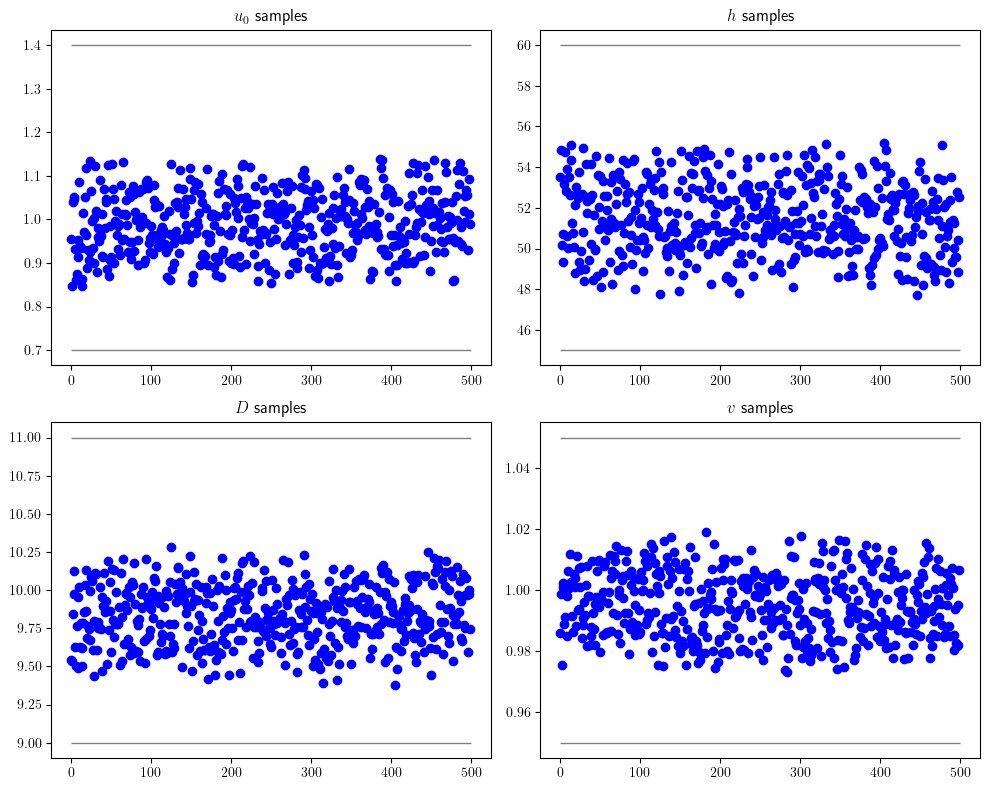

In [38]:
# Define simple bounds on each parameter space
U0min=0.7; U0max=1.4;
hmin=45; hmax=60;
Dmin=9; Dmax=11;
vmin=0.95; vmax=1.05; 

df = 4  # degrees of freedom for the asymptotic threshold value
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M_samples = 1000  # Number of samples to be drawn
Usampled = np.zeros(M_samples)
hsampled = np.zeros(M_samples)
Dsampled = np.zeros(M_samples)
vsampled = np.zeros(M_samples)
lls = np.zeros(M_samples)
kount = 0

# Sampling loop: rejection sampling based on the log-likelihood threshold
while kount < M_samples:
    U0g = uniform.rvs(loc=U0min, scale=U0max - U0min)  # Draw a random sample of U0
    hg = uniform.rvs(loc=hmin, scale=hmax - hmin)         # Draw a random sample of h
    Dg = uniform.rvs(loc=Dmin, scale=Dmax - Dmin)          # Draw a random sample of D
    vg = uniform.rvs(loc=vmin, scale=vmax - vmin)          # Draw a random sample of v
    params = np.array([U0g, hg, Dg, vg])
    log_likelihood = loglhood(data, params, L, Delta, T, xloc, sigma) - fmle
    if  log_likelihood >= llstar:
        lls[kount] = log_likelihood
        Usampled[kount] = U0g
        hsampled[kount] = hg
        Dsampled[kount] = Dg
        vsampled[kount] = vg
        kount += 1

# Plot samples of each parameter
fig9, axs9 = plt.subplots(2, 2, figsize=(10,8))
axs9[0,0].scatter(range(M_samples),Usampled, color='blue')
axs9[0,0].hlines([U0min,U0max], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[0,0].set_title(r"$u_0$ samples")
axs9[0,1].scatter(range(M_samples),hsampled, color='blue')
axs9[0,1].hlines([hmin,hmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[0,1].set_title(r"$h$ samples")
axs9[1,0].scatter(range(M_samples),Dsampled, color='blue')
axs9[1,0].hlines([Dmin,Dmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[1,0].set_title(r"$D$ samples")
axs9[1,1].scatter(range(M_samples),vsampled, color='blue')
axs9[1,1].hlines([vmin,vmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[1,1].set_title(r"$v$ samples")
plt.tight_layout()

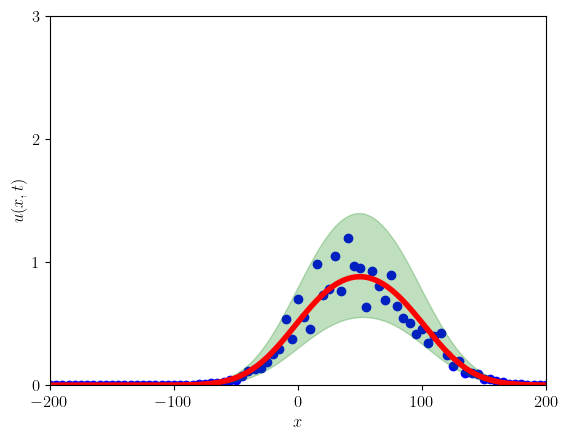

In [40]:
Delta_f = 1
Nf = int(2 * L / Delta_f) + 1
xlocf = np.zeros(Nf)
for i in range(1, Nf+1):
    xlocf[i-1] = -L + (i - 1) * Delta_f
# Set up a fine discretisation of -L < x < L with mesh spacing Delta_f for the prediction interval

lower_bound = 2 * U0 * np.ones(len(xlocf))  # Define vector on the fine spatial discretisation that will store the lower limit of the prediction interval
upper_bound = np.zeros(len(xlocf))    

# Precompute quantiles for Normal(0,σ)
q_lower = norm.ppf(0.05, loc=0, scale=sigma)
q_upper = norm.ppf(0.95, loc=0, scale=sigma)

for i in range(M_samples):
    def C(x, U0g=Usampled[i], hg=hsampled[i], Dg=Dsampled[i], vg=vsampled[i]):
        return U0g * (sp.erf((hg - (x - vg * T)) / np.sqrt(4 * Dg * T)) \
               + sp.erf((h + (x - vg * T)) / np.sqrt(4 * Dg * T))) / 2
    for j in range(len(xlocf)):
        c_val = C(xlocf[j])
        if c_val * np.exp(q_lower) < lower_bound[j]:  # For each location across the domain compute the lower bound of the noise model
            lower_bound[j] = c_val * np.exp(q_lower)  # For each location across the domain store the lower bound
        if c_val * np.exp(q_upper) > upper_bound[j]:  # For each location across the domain compute the upper bound of the noise model
            upper_bound[j] = c_val * np.exp(q_upper)  # For each location across the domain store the upper bound






# Plot the data, MLE solution and prediction intervals
fig10, ax10 = plt.subplots()
ax10.scatter(xloc, data, color='blue', label='_nolegend_')
ax10.plot(x_plot_line, [umle(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax10.set_xlabel(r"$x$",fontsize=12)
ax10.set_ylabel(r"$u(x,t)$",fontsize=12)
ax10.set_xlim(-L, L)
ax10.set_ylim(0, U0 + 0.1)
ax10.set_xticks([-200, -100, 0, 100, 200])
ax10.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax10.set_yticks([0, 1, 2, 3])
ax10.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax10.tick_params(labelsize=12)
# Plot the region that lies between the lower and upper bounds of the prediction intervals
ax10.plot(xlocf, lower_bound, lw=0, color='green')
ax10.fill_between(xlocf, lower_bound, upper_bound, color='green', alpha=0.25)
plt.show()